In [903]:
import os
import sys

import importlib
import dicom_utils
importlib.reload(dicom_utils)
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from skimage import data, morphology
from skimage.future import graph
from skimage.color import label2rgb
import networkx as nx
from scipy.ndimage.interpolation import shift

In [203]:
file_dir = os.path.join(os.getcwd(), "assets", "niftynet_raw_images")
print("Your files are/should be in ", file_dir)
patients = [int(x) for x in os.listdir(file_dir) if len(os.listdir(os.path.join(file_dir, str(x)))) > 0]
patients.sort()
print("\n\nYour available patient IDs are ", patients)

Your files are/should be in  /Users/eiofinova/niftynet/assets/niftynet_raw_images


Your available patient IDs are  [2, 3, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 64, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

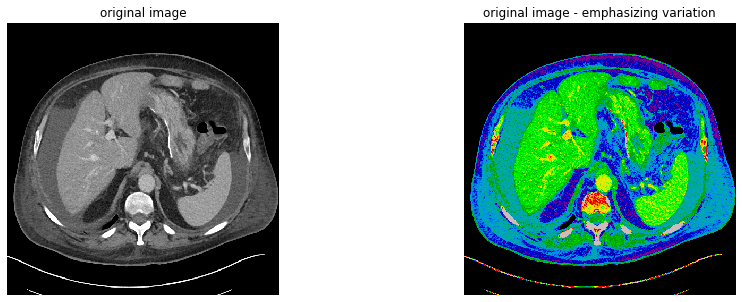

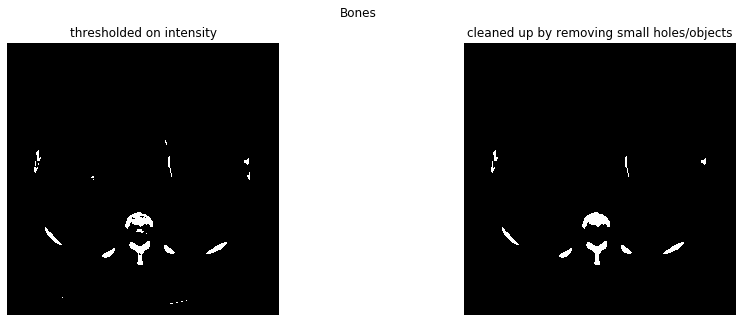

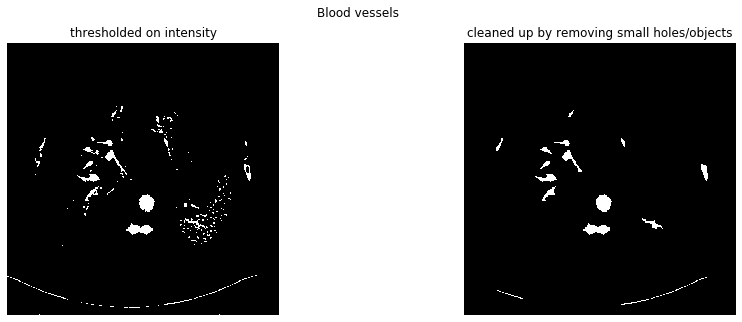

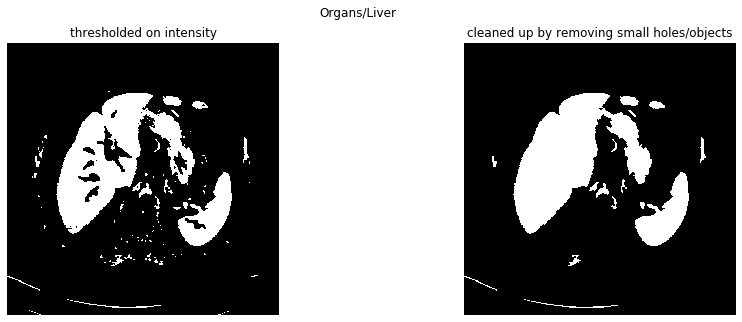

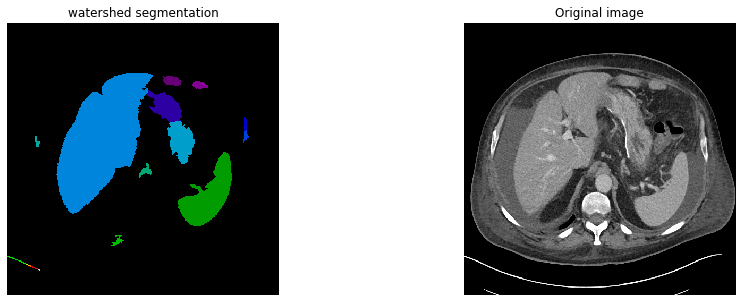

In [210]:
# Set these parameters
patient = 2
slice_idx = 169

# Optionally, also set these.
bones_thresh = [200, 2, 64]
blood_vessels_thresh = [160, 5, 64]
liver_thresh = [125, 1, 64]

# Probably better not to mess with anything below this.
img_path = "assets/niftynet_raw_images/%d/%d.png" % (patient, slice_idx)
img = skio.imread(img_path)

dicom_utils.show_scan(img)
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones")
img = img * (1 - mask)
mask = dicom_utils.partition_at_threshold(img, *blood_vessels_thresh, title="Blood vessels")
img = img * (1 - mask)
liver = dicom_utils.partition_at_threshold(img, *liver_thresh, title = "Organs/Liver")
dicom_utils.label_image(liver, orig=skio.imread(img_path))

In [459]:
def guess_bounds_1(regions_map, prev_regions_map):
    labels = np.nonzero(np.bincount(regions_map.flatten()))[0]
    prev_labels = np.nonzero(np.bincount(prev_regions_map.flatten()))[0]
    print("labels", labels, prev_labels)
    newliver = regions_map.copy()
    #ii = np.nonzero(bincounts)[0]
    label_idx = len(labels) + 1
    
    # Label all the new regions of the liver
    for rs0 in range(1, len(labels)):
        for rs1 in range(1, len(prev_labels)):
            union = regions_map == rs0
            #print(sum(union))
            union[prev_regions_map != rs1] = 0
            if union.sum() > 0:
                #print("newlabel", sum(union))
                newliver[union] = label_idx
                # this makes really cool pictures
                # livers[i][union] = len(regions[i]) + label_idx
                label_idx += 1
        liver_mask = newliver > 0
        #print(len(regions[i]))
        liver_mask[newliver >= len(labels)] = False
        liver_mask2 = label(liver_mask)
        # Create separate namespace for the new areas.
        newliver[liver_mask] = liver_mask2[liver_mask] + 100
        bincounts = np.bincount(newliver.flatten())
        ii = np.nonzero(bincounts)[0]
        adj = graph.RAG(newliver)
        mult_neighbors = []
        #print("hello", adj.nodes, [e for e in adj.edges if e[0] > 100 or e[1] > 100])
        for node in adj.nodes:
            if node > 100:
                edges = [edge for edge in adj.edges(node) if edge[0] != 0 and edge[1] != 0]
                if len(edges) == 1:
                    if edges[0][0] == node:
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][1]
                        pass
                    else:
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][0]
                        pass
                else:
                    mult_neighbors.append((node, [x for edge in edges for x in edge if x != node]))
        for region, neighbors in mult_neighbors:
            dists = []
            # Find distances to all the existing things.
            for neighbor in neighbors:
                mymask = np.ones_like(newliver)
                mymask[newliver == neighbor] = 0
                #print("myshape1", mymask.shape)
                mymask = ndi.distance_transform_edt(mymask)
                #print("myshape", mymask.shape)
                dists.append((neighbor, mymask))
            for io in range(newliver.shape[0]):
                for jo in range(newliver.shape[1]):
                    if newliver[io][jo] == region:
                        closest_region = -1
                        closest_distance = 10000
                        for n, d in dists:
                            #print(d.shape)
                            if d[io][jo] < closest_distance:
                                closest_distance = d[io][jo]
                                closest_region = n
                        if closest_region < 0:
                            continue
                        #loz[io][jo] = closest_region
    return newliver

In [486]:
# Find the liver on one good slice
# From there:
# For each thing that touches the liver and also touches something else:
# Estimate how much the liver and the other thing is growing in the neighborhood of that spot (use 90th percentile of distance to organ??)
# Partition the disputed pixels weighted by how much the organ would "want" to grow.


def find_liver(regions_map):
    bc= np.bincount(regions_map.flatten())
    print(np.nonzero(bc)[0])
    regs = [(x, bc[x]) for x in np.nonzero(bc)[0] if x > 0]
    regs = sorted(regs, key=lambda x: -1*x[1])
    print(regs)
    liver_label = regs[0][0]
    return liver_label
    

def guess_bounds_2(regions_map, prev_regions_map):
    
    liver_label = find_liver(prev_regions_map)
    
    
    
    labels = np.nonzero(np.bincount(regions_map.flatten()))[0]
    prev_labels = np.nonzero(np.bincount(prev_regions_map.flatten()))[0]
    print("labels", labels, prev_labels)
    newliver = regions_map.copy()
    
    
    # Find all the labels that touch liver_label
    prev_liver = prev_regions_map == liver_label
    
    relevant_regions_mask = np.zeros_like(regions_map)
    num_regions_found = []
    for rs0 in range(1, len(labels)):
        if np.sum((regions_map == rs0) * prev_liver) > 0:
            relevant_regions_mask[regions_map==rs0] = 1
            num_regions_found.append(rs0)
    if len(num_regions_found) == 1 and np.sum((regions_map == num_regions_found[0]) * prev_liver) > 0.9 * np.sum(relevant_regions_mask):
        return relevant_regions_mask
    
    
    # For each region in the new map, find whether it touches the liver. If not, we don't care about it
    # if yes and only touches the liver: assign to liver
    # if yes and touches another organ: see how
    
    return np.zeros_like(regions_map)

def distance_from(img, label):
    mask = ones_like(img)
    mask[img == label] = 0
    return ndi.distance_transform_edt(mask)
    

def guess_bounds_3(regions_map, prev_regions_map):
    labels = np.nonzero(np.bincount(regions_map.flatten()))[0]
    prev_labels = np.nonzero(np.bincount(prev_regions_map.flatten()))[0]
    print("labels", labels, prev_labels)
    newliver = regions_map.copy()
    #ii = np.nonzero(bincounts)[0]
    label_idx = len(labels) + 1
    
    # Label all the new regions of the liver
    for rs0 in range(1, len(labels)):
        for rs1 in range(1, len(prev_labels)):
            union = regions_map == rs0
            union[prev_regions_map != rs1] = 0
            if union.sum() > 0:
                newliver[union] = label_idx
                label_idx += 1
        liver_mask = newliver > 0
        #print(len(regions[i]))
        liver_mask[newliver >= len(labels)] = False
        liver_mask2 = label(liver_mask)
        # These are the areas that need labeling. Create separate namespace for the new areas.
        newliver[liver_mask] = liver_mask2[liver_mask] + 100
        adj = graph.RAG(newliver)
        neighbors = []
        for label in adj.nodes:
            if label > 100:  # This means it needs to be labeled
                edges = [edge for edge in adj.edges(node) if edge[0] != 0 and edge[1] != 0]
                if len(edges) == 1:  # If it's only touching one thing in the previous layer
                    if edges[0][0] == label: # The edge is either (a, b) or (b, a)
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][1]
                        # compute the average distance of the edgy thing to the organ
                        pass
                    else:
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][0]
                        pass
                else:
                    # for each disputed area, compute the average growth/shrinkage 
                    neighbors.append((label, [x for edge in edges for x in edge if x != label]))
        for label, neighbor_labels in neighbors:
            for neighbor_label in neighbor_labels: #Neighbor label are original labels
                old_labels_neighbors = [l for edge in adj.edges(neighbor_label) if edge[0] != 0 and edge[1] != 0
                                       for l in edge if l != neighbor_label]
                
                # Hacky way to find all neighbors that only touch the known area
                old_labels_neighbors = np.sum([newliver==l for l in old_labels_neighbors if len(adj.edges(l) == 2)])
                old_labels_neighbors = distance_from(newliver, old_label)
                old_labels_neighbors = [x for x in np.flatten(old_labels_neighbors) if x > 0]
                opt_distance = np.percentile(old_labels_neighbors, 90) + 1
                
            # Find distances to all the existing things.
            for neighbor in neighbors:
                dists.append((neighbor, mymask))
            for io in range(newliver.shape[0]):
                for jo in range(newliver.shape[1]):
                    if newliver[io][jo] == region:
                        closest_region = -1
                        closest_distance = 10000
                        for n, d in dists:
                            #print(d.shape)
                            if d[io][jo] < closest_distance:
                                closest_distance = d[io][jo]
                                closest_region = n
                        if closest_region < 0:
                            continue
                        #loz[io][jo] = closest_region
    return newliver
 

In [847]:
# Expand by 5(?) pixels in each direction
# Filter by the labels in the current frame
# see how the center of mass and area has moved
# adjust every region by the new volume/center of mass
# All intersections and leftover unlabeled regions become splits

def distance_from(img, label):
    mask = ones_like(img)
    mask[img == label] = 0
    return ndi.distance_transform_edt(mask)

def guess_bounds_4(regions_map, prev_regions_map):
        regions = regionprops(prev_regions_map)
        new_regions = regionprops(regions_map)
        output = np.ones([regions_map.shape[0], regions_map.shape[1], len(regions)]) * 1000
        labelz = np.array([x.label for x in regions])
        for i, region in enumerate(regions):
            regmask = np.zeros_like(prev_regions_map)
            regmask[prev_regions_map == region.label] = 1
            regmask = morphology.dilation(regmask, morphology.square(3)) * regions_map > 0
            regmask = regmask.astype(np.int32)
            if np.sum(regmask) == 0:
                continue
            
            c1 = region.centroid
            c2 = regionprops(regmask)[0].centroid
            centroid_move = (round(c2[0]-c1[0]), round(c2[1]-c1[1]))
            growth_ratio = region.area - regionprops(regmask)[0].area
            rat = round(growth_ratio / max(region.perimeter, 1))
            rat = int(rat)
            expected_newslice = (prev_regions_map == region.label)

            expected_newslice = expected_newslice.astype(np.int32)
            if rat >= 1:
                expected_newslice = morphology.dilation(expected_newslice, morphology.square(rat))
            elif rat <= -1:
                expected_newslice = morphology.erosion(expected_newslice, morphology.square(-1*rat))
            expected_newslice = shift(expected_newslice, centroid_move, cval=0)

            output[:,:,i] = ndi.distance_transform_edt(np.ones_like(expected_newslice) - expected_newslice)
        next_region_id = labelz.max() + 1
        
        
        # make a map dict of which region touches which other region
        labelmap ={}
        for region in new_regions:
            labelmap[region.label] = [x for x in np.unique(prev_regions_map * (regions_map == region.label)) if x > 0]
        print("labelmap", labelmap)

            
        finalfinal = np.zeros_like(regions_map)
        for i in range(finalfinal.shape[0]):
            for j in range(finalfinal.shape[1]):
                pixel_val = regions_map[i,j]
                if pixel_val == 0 or not labelmap[pixel_val]:
                    continue
                poss_labels = labelmap[pixel_val]
                labels_idx = [list(labelz).index(x) for x in poss_labels]
                candidates = output[i][j][labels_idx]
                #TODO: this should be filtered by whether there is any intersection at all with this layer
                finalfinal[i][j] = poss_labels[list(candidates).index(min(candidates))]

        finalfinal = finalfinal * (regions_map > 0)


        for new_region in new_regions:
            if not ((regions_map == new_region.label) & (prev_regions_map > 0)).sum():
                finalfinal[regions_map == new_region.label] = next_region_id
                next_region_id += 1
        return finalfinal
    
def try_slice(regions_map, slicer_len=4):
    #slice means there's pattern of black-white-black
    #horizontal slices
    pos_map = regions_map > 0
    depths = ndi.distance_transform_edt(pos_map)

    for i in range(1, pos_map.shape[0] - 1):
        for j in range(1, pos_map.shape[1] - 1):
            if depths[i][j] in (1, 2, 3):
                sq = depths[i-1:i+1,j-1:j+1]
                sq[0, 0] = 0
                if sq.max() == 3:
                    regions_map[i-1:i+1,j-1:j+1] = 0
    return regions_map
                    #print("deleting pixel", i, j)
#                 for ii in range(-1,2):
#                     for jj in range(-1,2):
#                         if ii == 0 and jj == 0:
#                             continue
#                         if depths[i+ii,j+jj] == 0 and  depths[i-ii,j-jj] == 0:
#                             print("deleting pixel", i, j)
#                             regions_map[i, j] = 0
                            
                        
# img_path = "assets/niftynet_raw_images/1/170.jpg"
# img = skio.imread(img_path)
# liver = dicom_utils.partition_at_threshold(img, 130, 5, 64, title = "Organs/Liver", show_plot=False)
# try_slice(img)

/Users/eiofinova/niftynet
labelmap {1: [1], 2: [2], 3: [3], 4: [4], 5: [], 6: []}
labelmap {1: [2], 2: [1], 3: [4], 4: [3], 5: [9], 6: [], 7: [], 8: [3]}
labelmap {1: [2], 2: [1], 3: [4], 4: [3], 5: [9], 6: [], 7: [20], 8: [21], 9: [3], 10: []}
labelmap {1: [2], 2: [1], 3: [4], 4: [3], 5: [9], 6: [], 7: [21], 8: [3], 9: [3], 10: []}


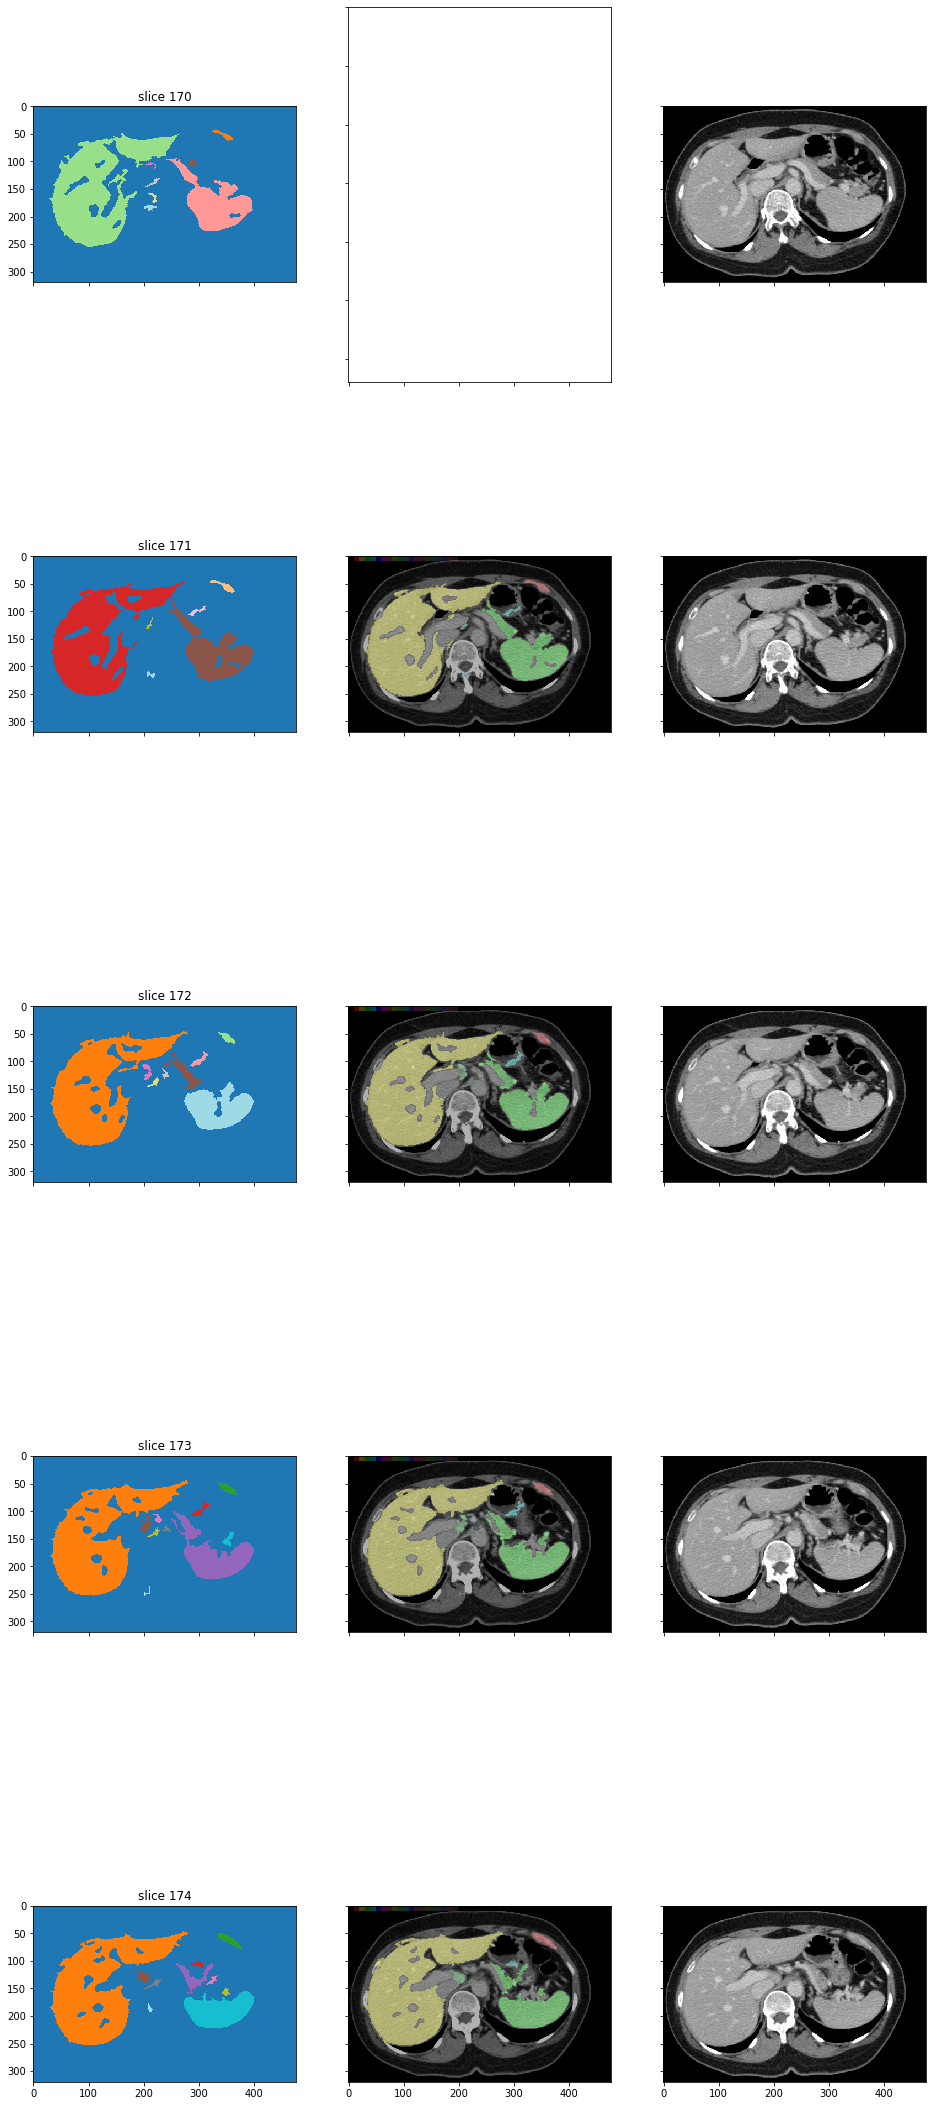

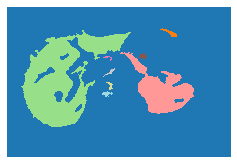

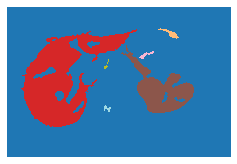

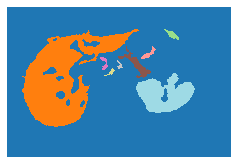

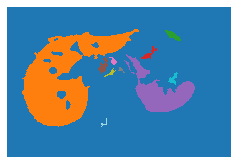

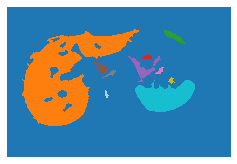

In [916]:
patients = {
    1: {"slice_idx":182, "bones_thresh": [170, 2, 64],
        "blood_vessels_thresh" : [158, 5, 64],
        "liver_thresh": [130, 1, 64],
       "reference_slide": 194}, #Enlarged spleen, 
    2: {"slice_idx":165, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [160, 5, 64], "liver_thresh": [125, 1, 64]},
    3: {"slice_idx":149, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [160, 5, 64], "liver_thresh": [125, 1, 64]},
    4: {"slice_idx":182, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [140, 1, 64]},
    5: {"slice_idx":155, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [170, 5, 64], "liver_thresh": [138, 1, 64]},
    7: {"slice_idx":166, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [140, 1, 64],
       "reference_slide": 168},
    8: {"slice_idx":186, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [165, 5, 64],
        "liver_thresh": [140, 1, 64]}, ## Slides 189 and 190 are corrupt (?)
    9: {"slice_idx":183, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [165, 5, 64],
        "liver_thresh": [125, 1, 64]},
    11: {"slice_idx":163, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [133, 1, 64]}, 
    12: {"slice_idx":175, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [125, 1, 64]}, # Really enlarged spleen
    13: {"slice_idx":165, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64], #Super cirrhotic liver + huge spleen
        "liver_thresh": [135, 1, 64], "reference_slice": 166},
    14: {"slice_idx":140, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [132, 1, 64],}, # Really large liver, hard to segment, really need to look into
                                        # bumping long dark areas
    16: {"slice_idx":190, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [120, 1, 64], "reference_slice": 166},
    40: {"slice_idx":150, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [125, 1, 64]},
    1001: {"slice_idx":170, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [135, 1, 64]},
}


importlib.reload(dicom_utils)
# Set these parameters
patient = 1001
patient_id = patient
pt = patients[patient]

slice_idx = pt["slice_idx"]
slice_interval = 1
num_slices = 5
print(os.getcwd())

fig, axes = plt.subplots(num_slices, 3, figsize=(16, num_slices * 8), sharey=True, sharex=True)
try:
    os.mkdir(os.path.join(os.getcwd(), "assets/masked_images", str(patient_id)))
except:
    pass

# Optionally, also set these.
bones_thresh = pt["bones_thresh"]
blood_vessels_thresh = pt["blood_vessels_thresh"]
#blood_vessels_thresh = [160, 5, 64]
liver_thresh = pt["liver_thresh"]

livers = [None] * num_slices
regions = [None] * num_slices
# Probably better not to mess with anything below this.

for i in range(num_slices):
    
    img_path = "assets/niftynet_raw_images/%d/%d.jpg" % (patient, slice_idx + i)
    img = skio.imread(img_path)
    #img = img.copy()
    axes[i, 2].imshow(img, cmap=plt.cm.gray)
    #dicom_utils.show_scan(img)
    mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
    imgb = img.copy() * (1 - mask)
    mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
    imgb = imgb * (1 - mask)
    liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
    livers[i] = label(liver)

    #livers[i] = try_slice(liver)

    axes[i, 0].imshow(livers[i], cmap=plt.cm.tab20)
    #plt.savefig("assets/masked_images/" + str(patient_id) + "/" + str(slice_idx + i) + ".png", format="png")
    dicom_utils.print_img(livers[i], "assets/masked_images/" + str(patient_id) + "/" + str(slice_idx + i))
    axes[i, 0].set_title('slice ' + str(slice_idx + i))

    # For each object, see which objects (on either side) it overlaps at least 50%.
    # if it overlaps just one object, then just check that the boundary is pretty skinny
    # If it overlaps two objects (ABOVE N SIZE??), divide it between them watershed.
    # Any skinny connector between them gets removed.

    if i > 0:
        newliver = guess_bounds_4(livers[i], livers[i-1])
        livers[i] = newliver

        if False:
            for il in range(26):
                newliver[il*20+1, :] = 100
                newliver[il*20, :] = 100
                newliver[:,il*20] = 100
                newliver[:,il*20+1] = 100
        for j in range(20):
            newliver[0:10,10*j:10*j+10] = j
        axes[i, 1].imshow(label2rgb(newliver, bg_label=0, colors=RGB_tuples, image=img/256))

        
    #if i < num_slices - 1:
    #    newliver = guess_bounds_1(livers[i], livers[i+1])
    #    axes[i, 2].imshow(newliver, cmap=plt.cm.nipy_spectral)


In [ ]:
import colorsys
N = 36
p = 6
myn = [int(i/p) + (i%p)*p for i in range(N)]
myn2 = [0.9 - int(i/p)/(p-1)*0.9 for i in range(N)]
myn3 = [1-(0.9 - int(i/p)/(p-1)*0.9) for i in range(N)]
print(myn2)
print(myn)
HSV_tuples = [(myn[x]*1.0/N, myn2[x], myn2[x]) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

RGB_tuples

In [ ]:
def print_slice(patient_id, slice_number, masked=False):
    